# 基于 LoRA 的 BERT 文本情感分类

### 一、任务目标

本任务旨在利用参数高效微调方法（LoRA）对预训练语言模型 BERT 进行文本分类训练，在 IMDb 电影评论数据集上完成二分类情感分析任务（正面 / 负面）。
通过引入 LoRA（Low-Rank Adaptation），在冻结大部分 BERT 参数的前提下，仅对少量可训练参数进行更新，以达到降低显存占用、减少训练成本、保持模型性能的目的。

### 二、整体流程概述

代码整体流程如下：

基础环境与超参数配置、IMDb 数据集加载与分词预处理、加载预训练 BERT 并注入 LoRA 结构、构建优化器与学习率调度器、模型训练（Training）、模型评估（Evaluation）、多轮 Epoch 训练与结果输出

In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from peft import LoraConfig, get_peft_model
from tqdm import tqdm

# =====================
# 1. 基本配置
# =====================
MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2
BATCH_SIZE = 8
EPOCHS = 3
LR = 2e-5
MAX_LEN = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", DEVICE)

# =====================
# 2. 加载数据集（IMDb）
# =====================
dataset = load_dataset("imdb")

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

dataset = dataset.map(tokenize_fn, batched=True)
dataset = dataset.remove_columns(["text"])
dataset.set_format("torch")

train_loader = DataLoader(
    dataset["train"],
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset["test"],
    batch_size=BATCH_SIZE
)

# =====================
# 3. 加载 BERT + LoRA
# =====================
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
model.to(DEVICE)

model.print_trainable_parameters()

# =====================
# 4. 优化器 & 学习率调度
# =====================
optimizer = AdamW(model.parameters(), lr=LR)

num_training_steps = EPOCHS * len(train_loader)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

loss_fn = torch.nn.CrossEntropyLoss()

# =====================
# 5. 训练函数
# =====================
def train_one_epoch(model, dataloader):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"]
        )

        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# =====================
# 6. 测试函数
# =====================
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

        preds = torch.argmax(outputs.logits, dim=-1)
        correct += (preds == batch["label"]).sum().item()
        total += batch["label"].size(0)

    return correct / total

# =====================
# 7. 主训练流程
# =====================
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader)
    acc = evaluate(model, test_loader)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {acc:.4f}")

print("Training finished.")


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700

Epoch 1/3


Evaluating: 100%|██████████| 3125/3125 [01:35<00:00, 32.78it/s]


Train Loss: 0.5526
Test Accuracy: 0.8336

Epoch 2/3


Evaluating: 100%|██████████| 3125/3125 [01:35<00:00, 32.73it/s]


Train Loss: 0.3729
Test Accuracy: 0.8467

Epoch 3/3


Evaluating: 100%|██████████| 3125/3125 [01:35<00:00, 32.81it/s]

Train Loss: 0.3538
Test Accuracy: 0.8500
Training finished.



# 基于 LoRA Rank 的 BERT 情感分类消融实验

### 一、实验任务目标

本实验在 IMDb 情感分类任务上，系统研究 LoRA（Low-Rank Adaptation）中低秩参数 r 对模型性能与参数规模的影响，通过控制变量法比较不同 LoRA rank 设置下：

可训练参数数量变化、训练损失收敛情况、测试集分类准确率变化

从而分析 LoRA 在参数效率与模型性能之间的权衡关系，为参数高效微调方法的合理配置提供实验依据。

### 二、实验整体流程概述

代码整体可划分为六个主要阶段：

基础配置与实验变量定义、IMDb 数据集加载与分词预处理、训练与评估函数定义、LoRA rank 消融实验主循环、实验结果可视化（曲线绘制）、可用表格结果输出

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Using device: cuda

===== LoRA rank = 2 =====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 75266 || all params: 109559044 || trainable%: 0.0687

Epoch 1/3


Evaluating: 100%|██████████| 3125/3125 [01:35<00:00, 32.82it/s]


Train Loss: 0.5452 | Test Accuracy: 0.8306

Epoch 2/3


Evaluating: 100%|██████████| 3125/3125 [01:35<00:00, 32.59it/s]


Train Loss: 0.3756 | Test Accuracy: 0.8447

Epoch 3/3


Evaluating: 100%|██████████| 3125/3125 [01:35<00:00, 32.63it/s]


Train Loss: 0.3570 | Test Accuracy: 0.8514

===== LoRA rank = 4 =====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 148994 || all params: 109632772 || trainable%: 0.1359

Epoch 1/3


Evaluating: 100%|██████████| 3125/3125 [01:36<00:00, 32.24it/s]


Train Loss: 0.5196 | Test Accuracy: 0.8374

Epoch 2/3


Evaluating: 100%|██████████| 3125/3125 [01:36<00:00, 32.39it/s]


Train Loss: 0.3675 | Test Accuracy: 0.8479

Epoch 3/3


Evaluating: 100%|██████████| 3125/3125 [01:36<00:00, 32.37it/s]


Train Loss: 0.3511 | Test Accuracy: 0.8520

===== LoRA rank = 8 =====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 296450 || all params: 109780228 || trainable%: 0.2700

Epoch 1/3


Evaluating: 100%|██████████| 3125/3125 [01:35<00:00, 32.63it/s]


Train Loss: 0.5237 | Test Accuracy: 0.8248

Epoch 2/3


Evaluating: 100%|██████████| 3125/3125 [01:35<00:00, 32.65it/s]


Train Loss: 0.3744 | Test Accuracy: 0.8479

Epoch 3/3


Evaluating: 100%|██████████| 3125/3125 [01:35<00:00, 32.78it/s]


Train Loss: 0.3556 | Test Accuracy: 0.8496

===== LoRA rank = 16 =====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 591362 || all params: 110075140 || trainable%: 0.5372

Epoch 1/3


Evaluating: 100%|██████████| 3125/3125 [01:36<00:00, 32.23it/s]


Train Loss: 0.5156 | Test Accuracy: 0.8417

Epoch 2/3


Evaluating: 100%|██████████| 3125/3125 [01:36<00:00, 32.33it/s]


Train Loss: 0.3591 | Test Accuracy: 0.8504

Epoch 3/3


Evaluating: 100%|██████████| 3125/3125 [01:36<00:00, 32.40it/s]


Train Loss: 0.3405 | Test Accuracy: 0.8555


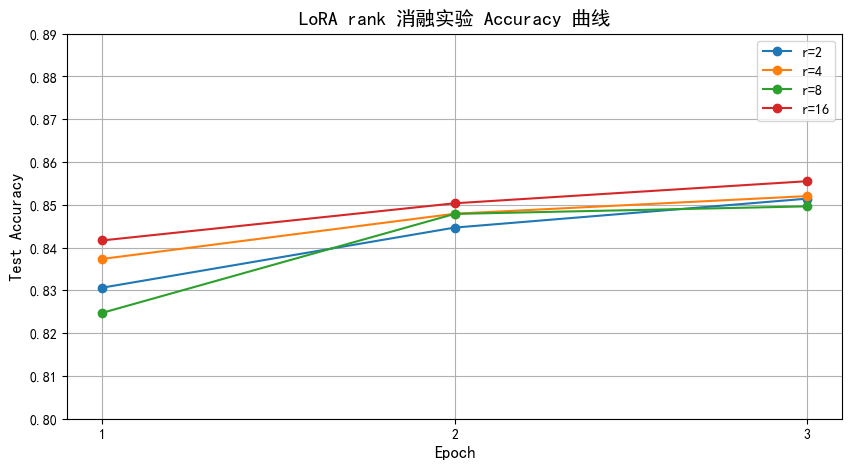


===== LoRA 消融实验汇总 =====
Rank | Trainable Params | Total Params | Trainable% | Final Test Accuracy
   2 |          75266 |   109559044 | 0.0687% | 0.8514
   4 |         148994 |   109632772 | 0.1359% | 0.8520
   8 |         296450 |   109780228 | 0.2700% | 0.8496
  16 |         591362 |   110075140 | 0.5372% | 0.8555


In [3]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from peft import LoraConfig, get_peft_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt

import os

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"

from datasets import load_dataset

dataset = load_dataset(
    "imdb",
    cache_dir="./hf_cache"
)

print(dataset)


matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
matplotlib.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# =====================
# 1. 基本配置
# =====================
MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2
BATCH_SIZE = 8
EPOCHS = 3
LR = 2e-5
MAX_LEN = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANKS = [2, 4, 8, 16]  # LoRA 消融实验 r 值

print("Using device:", DEVICE)

# =====================
# 2. 加载数据集
# =====================
dataset = load_dataset("imdb")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

dataset = dataset.map(tokenize_fn, batched=True)
dataset = dataset.remove_columns(["text"])
dataset.set_format("torch")

train_loader = DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset["test"], batch_size=BATCH_SIZE)

# =====================
# 3. 定义训练和评估函数
# =====================
def train_one_epoch(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["label"])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(dataloader)

@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        preds = torch.argmax(outputs.logits, dim=-1)
        correct += (preds == batch["label"]).sum().item()
        total += batch["label"].size(0)
    return correct / total

# =====================
# 4. LoRA 消融实验
# =====================
results = []

for r in RANKS:
    print(f"\n===== LoRA rank = {r} =====")
    model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
    lora_config = LoraConfig(
        r=r,
        lora_alpha=16,
        target_modules=["query", "value"],
        lora_dropout=0.1,
        bias="none",
        task_type="SEQ_CLS"
    )
    model = get_peft_model(model, lora_config)
    model.to(DEVICE)

    # 参数统计
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"trainable params: {trainable_params} || all params: {total_params} || trainable%: {trainable_params/total_params*100:.4f}")

    # 优化器与调度器
    optimizer = AdamW(model.parameters(), lr=LR)
    num_training_steps = EPOCHS * len(train_loader)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*num_training_steps), num_training_steps=num_training_steps)

    # 训练 & 评估
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        train_loss = train_one_epoch(model, train_loader, optimizer, scheduler)
        acc = evaluate(model, test_loader)
        print(f"Train Loss: {train_loss:.4f} | Test Accuracy: {acc:.4f}")
        epoch_losses.append(train_loss)
        epoch_accuracies.append(acc)

    # 保存结果
    results.append({
        "rank": r,
        "trainable_params": trainable_params,
        "total_params": total_params,
        "trainable_percent": trainable_params/total_params*100,
        "epoch_losses": epoch_losses,
        "epoch_accuracies": epoch_accuracies
    })

# =====================
# 5. 绘制消融实验曲线
# =====================
plt.figure(figsize=(10,5))
for res in results:
    plt.plot(range(1, EPOCHS+1), res["epoch_accuracies"], marker='o', label=f"r={res['rank']}")
plt.title("LoRA rank 消融实验 Accuracy 曲线", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xticks(range(1, EPOCHS+1))
plt.yticks([i/100 for i in range(80, 90, 1)])  # 可根据准确率范围调整
plt.legend()
plt.grid(True)
plt.savefig("lora_rank_accuracy_curve.png", dpi=300)
plt.show()


# =====================
# 6. 输出论文可用表格
# =====================
print("\n===== LoRA 消融实验汇总 =====")
print("Rank | Trainable Params | Total Params | Trainable% | Final Test Accuracy")
for res in results:
    print(f"{res['rank']:>4} | {res['trainable_params']:>14} | {res['total_params']:>11} | {res['trainable_percent']:.4f}% | {res['epoch_accuracies'][-1]:.4f}")



# 全参数微调（Full Fine-tuning）对照实验

本实验实现 BERT 的全参数微调（Full Fine-tuning），作为 LoRA 参数高效微调实验的对照基线（Baseline）。
通过在相同数据集、相同训练配置下训练不含 LoRA 的完整 BERT 模型，比较：

可训练参数规模、训练成本差异、测试集分类准确率

从而系统分析 参数高效微调（LoRA）与传统全参数微调之间的性能与效率权衡。

In [4]:
print("\n===== Full Fine-tuning =====")

# 加载模型（不加 LoRA）
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)
model.to(DEVICE)

# 参数统计
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"trainable params: {trainable_params} || all params: {total_params} || trainable%: {trainable_params/total_params*100:.4f}")

# 优化器 & 调度器
optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = EPOCHS * len(train_loader)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

# 训练
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler)
    acc = evaluate(model, test_loader)
    print(f"Train Loss: {train_loss:.4f} | Test Accuracy: {acc:.4f}")

full_ft_accuracy = acc



===== Full Fine-tuning =====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 109483778 || all params: 109483778 || trainable%: 100.0000

Epoch 1/3


Evaluating: 100%|██████████| 3125/3125 [01:32<00:00, 33.82it/s]


Train Loss: 0.3614 | Test Accuracy: 0.8790

Epoch 2/3


Evaluating: 100%|██████████| 3125/3125 [01:32<00:00, 33.89it/s]


Train Loss: 0.1917 | Test Accuracy: 0.8873

Epoch 3/3


Evaluating: 100%|██████████| 3125/3125 [01:32<00:00, 33.88it/s]

Train Loss: 0.0708 | Test Accuracy: 0.8925
